ANALASYING AND PREDICTING THE TITANIC DATASET

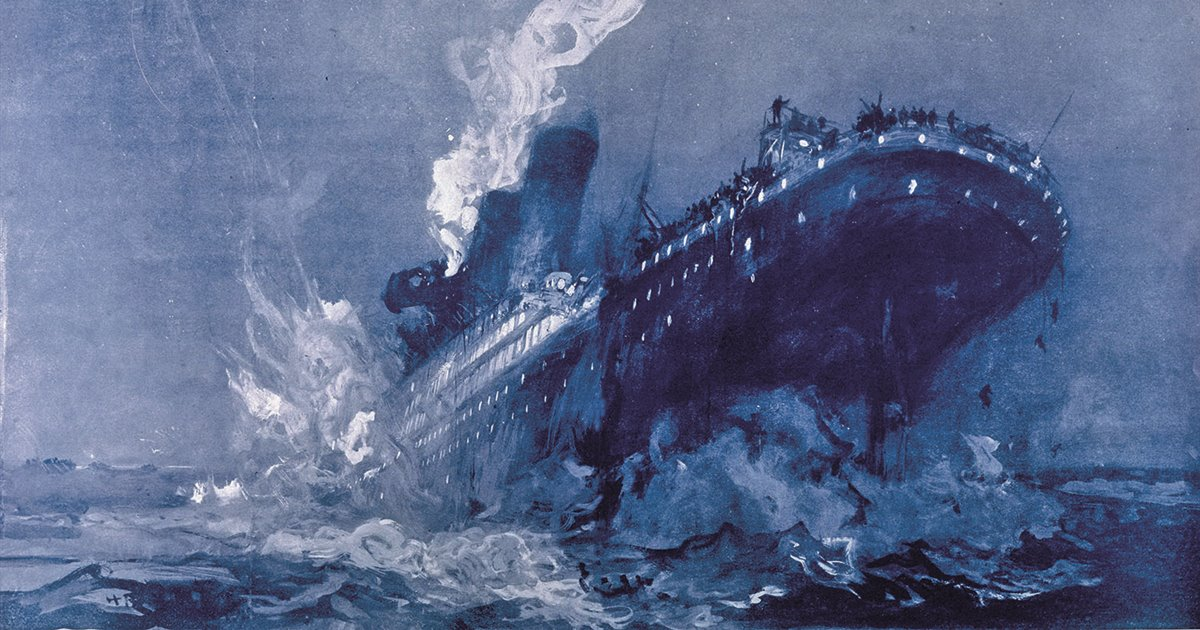

In [2]:
from IPython.display import display, Image
display(Image(filename="TITANIC.jpg"))

ANALISYING DATA

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


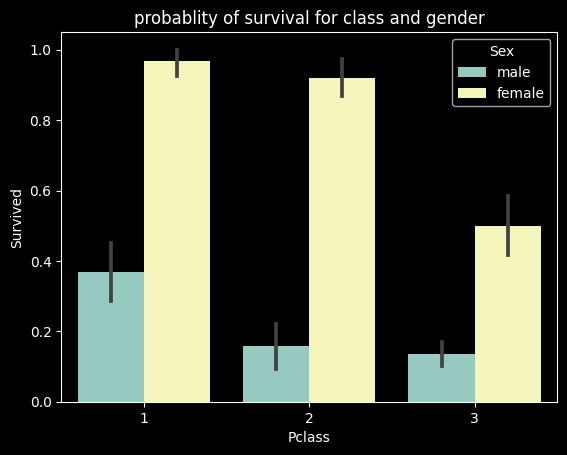

In [10]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

db=pd.read_csv("titanic.csv")
print(db.head())
sns.barplot(x="Pclass", hue="Sex", y="Survived", data=db)
plt.title("probablity of survival for class and gender")
plt.style.use("dark_background")


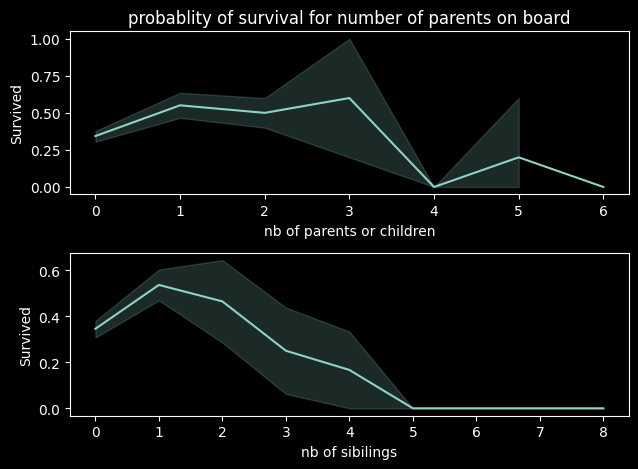

In [4]:
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1)
sns.lineplot(x="Parch", y="Survived", data=db, ax=ax1)
ax1.set_title("probablity of survival for number of parents on board")
sns.lineplot(x="SibSp", y="Survived", data=db, ax=ax2)
ax1.set_xlabel("nb of parents or children")
ax2.set_xlabel("nb of sibilings")
plt.tight_layout()




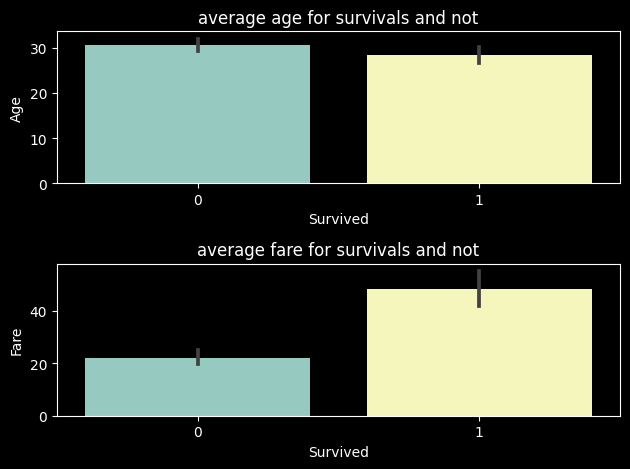

In [5]:

gruppo=db[["Age","Survived"]].dropna()
# print(gruppo["Age"].unique())
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1)
sns.barplot(x="Survived", y="Age", data=gruppo, ax=ax1)
# print(gruppo.head(20))
ax1.set_title("average age for survivals and not")
gruppo2=db[["Survived","Fare"]].dropna()
# print(gruppo2.head())
sns.barplot(x="Survived", y="Fare", data=gruppo2, ax=ax2)
ax2.set_title("average fare for survivals and not")
plt.tight_layout()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


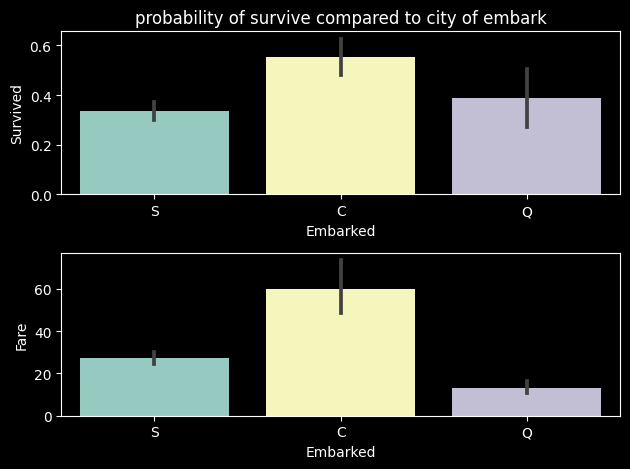

In [6]:
gruppo3=db[["Survived", "Embarked","Fare"]].dropna()
print(gruppo3["Embarked"].value_counts())
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1)
sns.barplot(x="Embarked", y="Survived", data=gruppo3, ax=ax1)
ax1.set_title("probability of survive compared to city of embark")
sns.barplot(x="Embarked", y="Fare", data=gruppo3, ax=ax2)
plt.tight_layout()
# People embarked in Cherbourg had more probability to survive because their fare is bigger on average

STUDYING DATA DISTRIBUITION


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

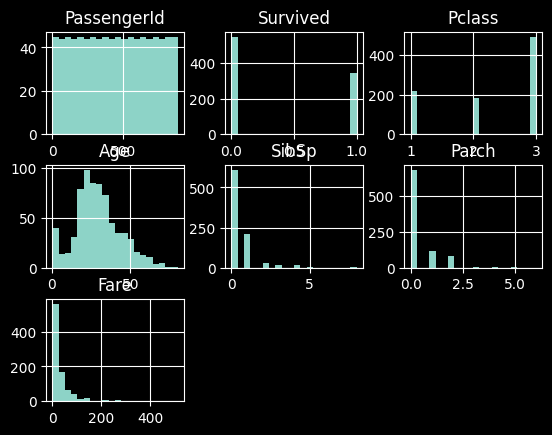

In [7]:
#studying distribuition of data

db.hist(bins=20)

MACHINE LEARNING

Survived    float64
Pclass      float64
Sex         float64
Age         float64
SibSp       float64
Parch       float64
Fare        float64
Embc        float64
Embq        float64
Embs        float64
dtype: object
  variables        VIF
8      Embs  23.767028
6      Embc   5.867503
7      Embq   2.367444
0    Pclass   1.787877
5      Fare   1.642596
2       Age   1.315598
4     Parch   1.289833
3     SibSp   1.283151
1       Sex   1.121939


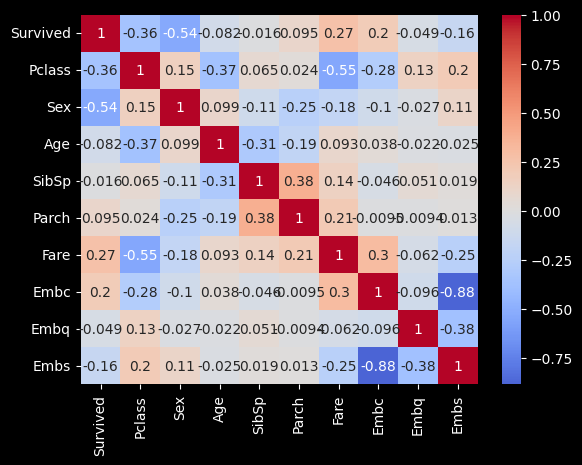

In [8]:
#Preparing data for machine learning
db1=db.drop(columns=["Cabin","PassengerId","Name","Ticket"]).dropna()
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
db1.loc[db1["Sex"]=="male","Sex"]=1.0
db1.loc[db1["Sex"]=="female","Sex"]=0.0
db1[["Age","Fare"]]=MinMaxScaler().fit_transform(db1[["Age","Fare"]])
x=OneHotEncoder(sparse_output=False)
db1["Embc"],db1["Embq"],db1["Embs"]=x.fit_transform(db1[["Embarked"]]).T
db1=db1.drop(columns="Embarked")
# print(db1.head())
db1=db1.astype(float)
print(db1.dtypes)

#studying correlations and vif

cor=db1.corr().stack().reset_index()
cor.columns=["var1","var2","cor"]
cor=cor[cor["var1"]!=cor["var2"]].sort_values(by="cor", ascending=False)
sns.heatmap(db1.corr(), annot=True, cmap="coolwarm", center=0)
# print(cor)

from statsmodels.stats.outliers_influence import variance_inflation_factor
def cal_vif(x):
    vif=pd.DataFrame()
    vif["variables"]=x.columns
    vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    vif=vif.sort_values(by=["VIF"],ascending=False)
    return vif
print(cal_vif(db1.drop(columns="Survived")))





In [9]:
# Chosing the model

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
x=db1.drop(columns=["Survived","Embs"])
y=db1["Survived"]
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
result=cross_validate(model, x,y,cv=10)
print(result["test_score"].mean())

#Building the model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
grid={"n_estimators": [10, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5]}
search=GridSearchCV(estimator=model, param_grid=grid, cv=5)

xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.7, random_state=0)
search.fit(xtrain,ytrain)
bestmodel=search.best_estimator_
bestmodel.predict(xtrain)
# model.fit(xtrain,ytrain)
pred=bestmodel.predict(xtest)
# print(accuracy_score(ytest,pred))



0.8104460093896714
